In [ ]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
import os

In [4]:
df = pd.read_csv("data_daily.csv")
train = df.iloc[:300].copy(deep = True)
test = df.iloc[300:].copy(deep = True)

train.head()

NameError: name 'pd' is not defined

In [3]:
print(train.shape, test.shape)

NameError: name 'train' is not defined

In [42]:
print(train.dtypes)

# Date           object
Receipt_Count     int64
dtype: object


In [43]:
train['Date'] = pd.to_datetime(train["# Date"],format='%Y-%m-%d') 
test['Date'] = pd.to_datetime(test["# Date"],format='%Y-%m-%d') 

In [44]:
for i in (train, test):
    i['year']=i.Date.dt.year 
    i['month']=i.Date.dt.month 
    i['day']=i.Date.dt.day    


In [45]:
train.head()

,# Date,Receipt_Count,Date,year,month,day
0,2021-01-01,7564766,2021-01-01,2021,1,1
1,2021-01-02,7455524,2021-01-02,2021,1,2
2,2021-01-03,7095414,2021-01-03,2021,1,3
3,2021-01-04,7666163,2021-01-04,2021,1,4
4,2021-01-05,7771289,2021-01-05,2021,1,5


<Axes: xlabel='month'>

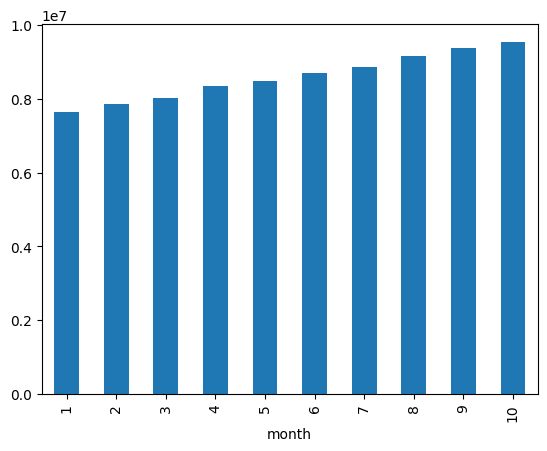

In [46]:
train.groupby('month')["Receipt_Count"].agg("mean").plot.bar()

<Axes: xlabel='month'>

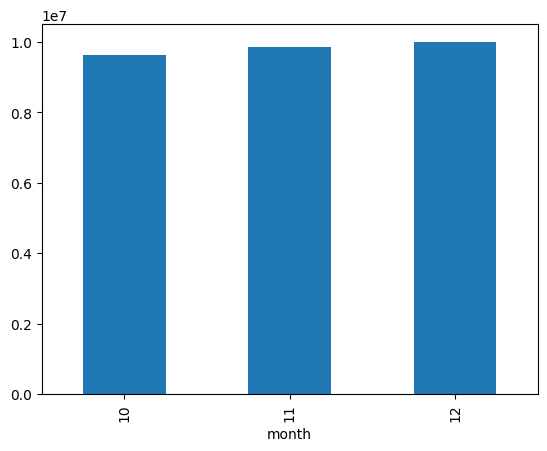

In [47]:
test.groupby('month')["Receipt_Count"].agg("mean").plot.bar()

Modelling

In [48]:
valid = train.iloc[250:300]
train = train.iloc[:250]

print(train.shape, valid.shape)

(250, 6) (50, 6)


In [51]:
#1: Naive (Next expected point is equal to the last observed point)

dd = np.asarray(train["Receipt_Count"]) 
y_pred = valid.copy() 
y_pred['naive'] = dd[len(dd)-1] 

In [1]:
plt.figure(figsize=(12,8)) 
plt.plot(train.index, train['Receipt_Count'], label='Train') 
plt.plot(valid.index,valid['Receipt_Count'], label='Valid') 
plt.plot(y_pred.index,y_pred['Receipt_Count'], label='Naive') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()
plt.savefig('plots/Naive_Forecast')

NameError: name 'plt' is not defined

In [54]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid["Receipt_Count"], y_pred["naive"])) 
print(rms)

322528.7401798792


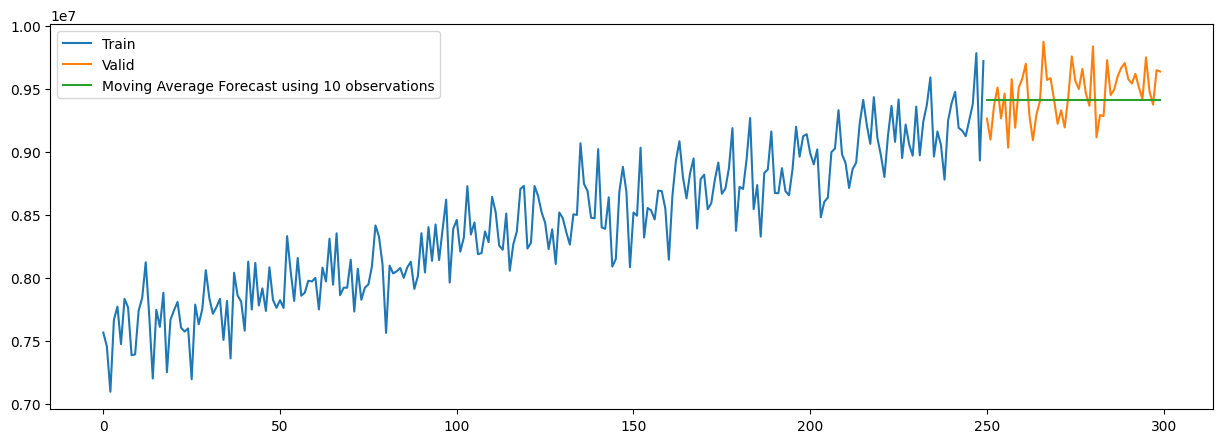

205290.3687280531


In [59]:
# 2) Moving average of 5,8,10

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = train['Receipt_Count'].rolling(5).mean().iloc[-1] 
plt.figure(figsize=(15,5)) 
plt.plot(train['Receipt_Count'], label='Train') 
plt.plot(valid['Receipt_Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], 
                label='Moving Average Forecast using 10 observations')

plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid["Receipt_Count"], y_hat_avg['moving_avg_forecast'])) 
print(rms)

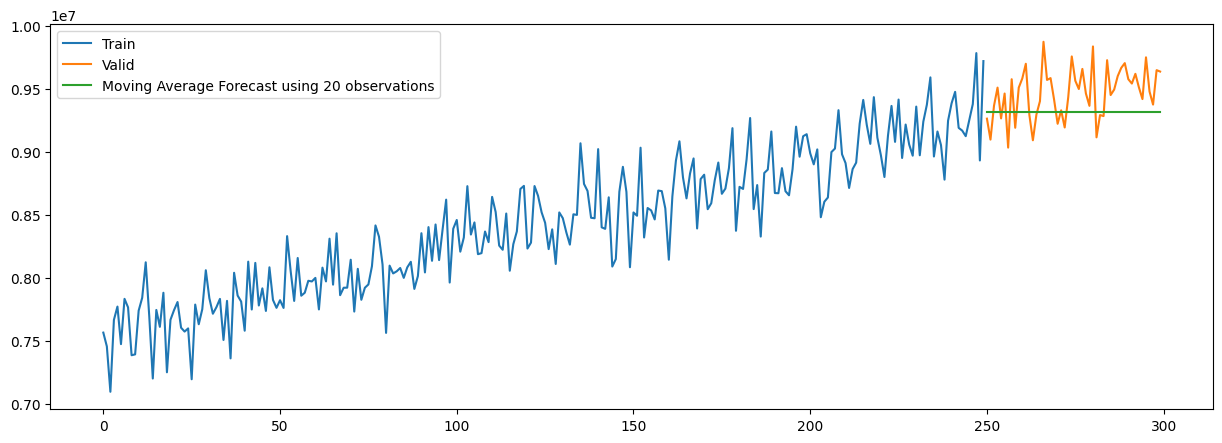

246997.52115579142


In [61]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = train['Receipt_Count'].rolling(8).mean().iloc[-1] 
plt.figure(figsize=(15,5)) 
plt.plot(train['Receipt_Count'], label='Train') 
plt.plot(valid['Receipt_Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], 
                label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid["Receipt_Count"], y_hat_avg['moving_avg_forecast'])) 
print(rms)

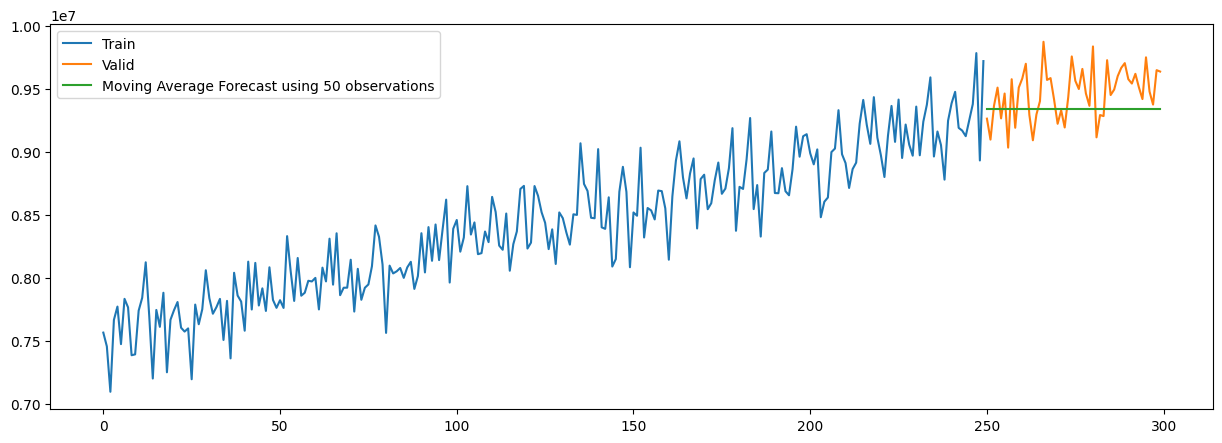

234362.15917521366


In [62]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = train['Receipt_Count'].rolling(10).mean().iloc[-1] 
plt.figure(figsize=(15,5)) 
plt.plot(train['Receipt_Count'], label='Train') 
plt.plot(valid['Receipt_Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], 
                    label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid["Receipt_Count"], y_hat_avg['moving_avg_forecast'])) 
print(rms)

In [65]:
print("Best RMS: Rolling 5 days : 205290.3687280531")

Best RMS: Rolling 5 days : 205290.3687280531


In [111]:
#3) Simple Exponetial Smoothing
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing 

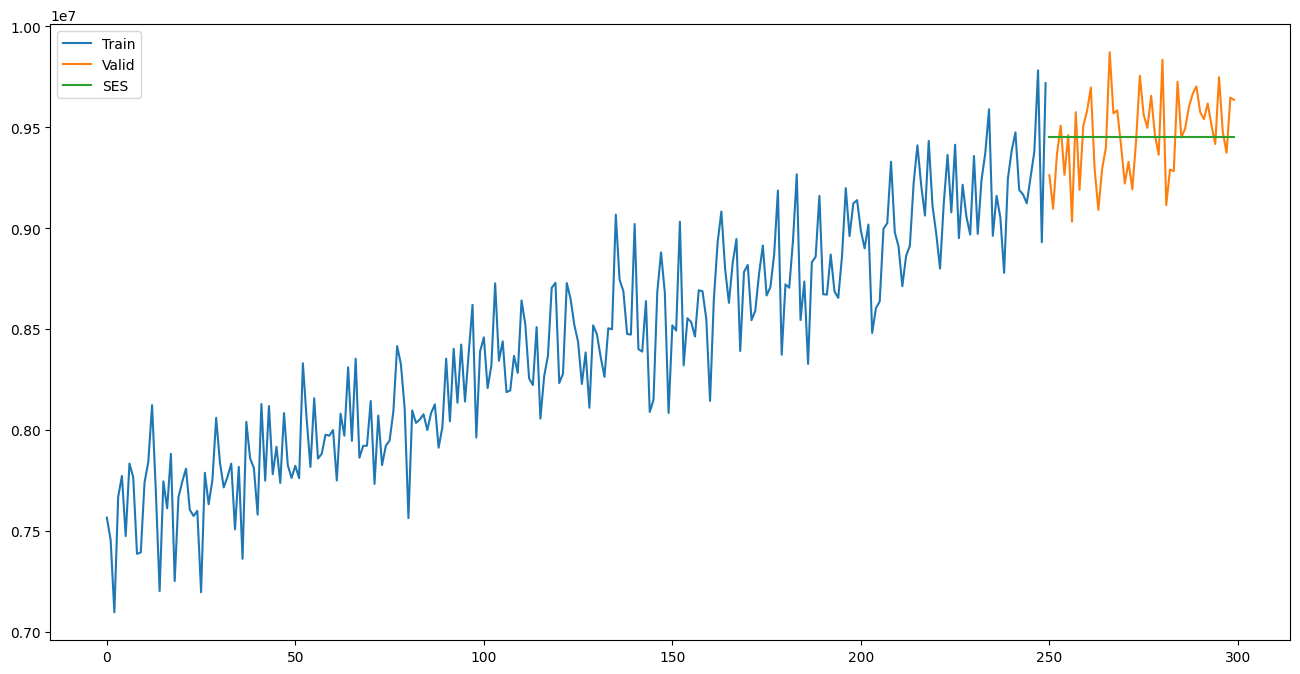

198989.53340226613


In [106]:

y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(train['Receipt_Count'])).fit(smoothing_level=0.42, optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid))

plt.figure(figsize=(16,8))  
plt.plot(train['Receipt_Count'], label='Train') 
plt.plot(valid['Receipt_Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid['Receipt_Count'], y_hat_avg['SES'])) 
print(rms)

Best method: Simple Exponetial Smoothing - RMS: 198989.53340226613

In [88]:
# Combine Train and Val, train the model again and test

train_combined = pd.concat([train ,valid])
train_combined.shape

(300, 6)

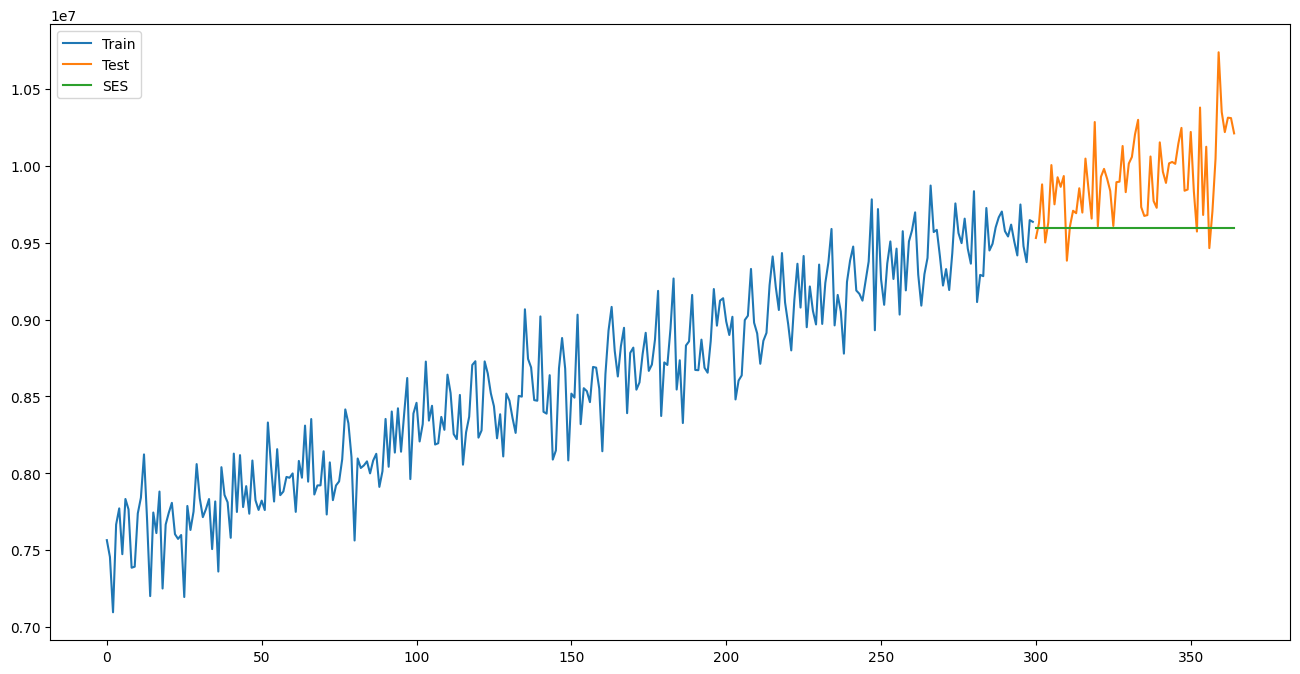

411883.8676344548


In [109]:

y_hat_avg = test.copy() 
fit2 = SimpleExpSmoothing(np.asarray(train_combined['Receipt_Count'])).fit(smoothing_level=1.36, optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(test))

plt.figure(figsize=(16,8))  
plt.plot(train_combined['Receipt_Count'], label='Train') 
plt.plot(test['Receipt_Count'], label='Test') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(test['Receipt_Count'], y_hat_avg['SES'])) 
print(rms)

In [110]:
fit2.save("best_model.pkl")

In [113]:
# Load the model:

best_model = sm.load('best_model.pkl')
y_hat_avg['SES'] = best_model.forecast(len(test))